# 영상 분할과 객체 검출  
  
1. 그랩컷으로 영상 분할
  
그랩컷  
• 그래프 컷(graph cut) 기반 영역 분할 알고리즘  
• 영상의 픽셀을 그래프 정점으로 간주하고, 픽셀들을 두 개의 그룹으로 나누는 최적의 컷(Max Flow Minimum Cut)을 찾는 방식  
  
그랩컷 영상 분할 동작 방식  
• 사각형 지정 자동 분할  
• 사용자가 지정한 전경/배경 정보를 활용하여 영상 분할  
  
그랩컷 함수  
**cv2.grabCut(img, mask, rect, bgdModel, fgdModel, iterCount, mode=None)**  
=> mask, bgdModel, fgdModel  
  
img: 입력 영상. 8비트 3채널.  
mask: 입출력 마스크. cv2.GC_BGD(0), cv2.GC_FGD(1), cv2.GC_PR_BGD(2),
cv2.GC_PR_FGD(3) 네 개의 값으로 구성됨.cv2.GC_INIT_WITH_RECT 모드로 초기화.  
rect: ROI 영역. cv2.GC_INIT_WITH_RECT 모드에서만 사용됨  
bgdModel: 임시 배경 모델 행렬. 같은 영상 처리 시에는 변경 금지.  
fgdModel: 임시 전경 모델 행렬. 같은 영상 처리 시에는 변경 금지.  
iterCount: 결과 생성을 위한 반복 횟수.  
mode: cv2.GC_로 시작하는 모드 상수. 보통 cv2.GC_INIT_WITH_RECT 모드로
초기화하고, cv2.GC_INIT_WITH_MASK 모드로 업데이트함.  









In [2]:
import sys
import numpy as np
import cv2


# 입력 영상 불러오기
src = cv2.imread('img/nemo.jpg')

if src is None:
    print('Image load failed!')
    sys.exit()

# 사각형 지정을 통한 초기 분할
rc = cv2.selectROI(src)  # 마우스 클릭으로 ROI 지정
mask = np.zeros(src.shape[:2], np.uint8)  # src.shape[x, y, 밝기값], 그레이스케일 이미지

cv2.grabCut(src, mask, rc, None, None, 5, cv2.GC_INIT_WITH_RECT)

# 0: cv2.GC_BGD, 2: cv2.GC_PR_BGD
mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')
#mask2 = np.where((mask == 0) , 0, 1).astype('uint8')
dst = src * mask2[:, :, np.newaxis]

# 초기 분할 결과 출력
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


In [3]:
import sys
import numpy as np
import cv2


# 입력 영상 불러오기
src = cv2.imread('img/football.png')

if src is None:
    print('Image load failed!')
    sys.exit()

# 사각형 지정을 통한 초기 분할
mask = np.zeros(src.shape[:2], np.uint8)  # 마스크
bgdModel = np.zeros((1, 65), np.float64)  # 배경 모델
fgdModel = np.zeros((1, 65), np.float64)  # 전경 모델

rc = cv2.selectROI(src)

cv2.grabCut(src, mask, rc, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_RECT)

# 0: cv2.GC_BGD, 2: cv2.GC_PR_BGD
mask2 = np.where((mask == 0) | (mask == 2), 0, 1).astype('uint8')
dst = src * mask2[:, :, np.newaxis]

# 초기 분할 결과 출력
cv2.imshow('dst', dst)

# 마우스 이벤트 처리 함수 등록
def on_mouse(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(dst, (x, y), 3, (255, 0, 0), -1)
        cv2.circle(mask, (x, y), 3, cv2.GC_FGD, -1)
        cv2.imshow('dst', dst)
    elif event == cv2.EVENT_RBUTTONDOWN:
        cv2.circle(dst, (x, y), 3, (0, 0, 255), -1)
        cv2.circle(mask, (x, y), 3, cv2.GC_BGD, -1)
        cv2.imshow('dst', dst)
    elif event == cv2.EVENT_MOUSEMOVE:
        if flags & cv2.EVENT_FLAG_LBUTTON:
            cv2.circle(dst, (x, y), 3, (255, 0, 0), -1)
            cv2.circle(mask, (x, y), 3, cv2.GC_FGD, -1)
            cv2.imshow('dst', dst)
        elif flags & cv2.EVENT_FLAG_RBUTTON:
            cv2.circle(dst, (x, y), 3, (0, 0, 255), -1)
            cv2.circle(mask, (x, y), 3, cv2.GC_BGD, -1)
            cv2.imshow('dst', dst)


cv2.setMouseCallback('dst', on_mouse)

while True:
    key = cv2.waitKey()
    if key == 13:  # ENTER
        # 사용자가 지정한 전경/배경 정보를 활용하여 영상 분할
        cv2.grabCut(src, mask, rc, bgdModel, fgdModel, 1, cv2.GC_INIT_WITH_MASK)
        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        dst = src * mask2[:, :, np.newaxis]
        cv2.imshow('dst', dst)
    elif key == 27:
        break

cv2.destroyAllWindows()


2. 모멘트 기반 객체 검출  
  
모멘트(Moments)란?  
• 영상의 형태를 표현하는 일련의 실수값  
• 특정 함수 집합과의 상관 관계(correlation) 형태로 계산  
  
Hu의 7개 불변 모멘트(Hu's seven invariant moments)  
• 3차 이하의 정규화된 중심 모멘트를 조합하여 만든 7개의 모멘트 값  
• 영상의 크기, 회전, 이동, 대칭 변환에 불변  
  
모양 비교 함수  
cv2.matchShapes(contour1, contour2, method, parameter) => retval  

contour1: 첫 번째 외곽선 또는 그레이스케일 영상  
contour2: 두 번째 외곽선 또는 그레이스케일 영상  
method: 비교 방법 지정. cv2.CONTOURS_MATCH_I1, cv2.CONTOURS_MATCH_I2, 
cv2.CONTOURS_MATCH_I3 중 하나 사용.  
parameter: 사용되지 않음. 0 지정.  
retval: 두 외곽선 또는 그레이스케일 영상 사이의 거리(distance)  

▪ Hu의 불변모멘트를 이용하여 두 외곽선 또는 영상의 모양을 비교
=> 크기, 회전, 이동, 대칭 변환에 강인

In [1]:
import sys
import numpy as np
import cv2


# 영상 불러오기
obj = cv2.imread('img/spades.png', cv2.IMREAD_GRAYSCALE)
src = cv2.imread('img/symbols.png', cv2.IMREAD_GRAYSCALE)

if src is None or obj is None:
    print('Image load failed!')
    sys.exit()

# 객체 영상 외곽선 검출
_, obj_bin = cv2.threshold(obj, 128, 255, cv2.THRESH_BINARY_INV)
obj_contours, _ = cv2.findContours(obj_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
obj_pts = obj_contours[0]

# 입력 영상 분석
_, src_bin = cv2.threshold(src, 128, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(src_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# 결과 영상
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)

# 입력 영상의 모든 객체 영역에 대해서
for pts in contours:
    if cv2.contourArea(pts) < 1000:
        continue

    rc = cv2.boundingRect(pts)
    cv2.rectangle(dst, rc, (255, 0, 0), 1)

    # 모양 비교
    dist = cv2.matchShapes(obj_pts, pts, cv2.CONTOURS_MATCH_I3, 0)

    cv2.putText(dst, str(round(dist, 4)), (rc[0], rc[1] - 3),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1, cv2.LINE_AA)

    if dist < 0.1:
        cv2.rectangle(dst, rc, (0, 0, 255), 2)

cv2.imshow('obj', obj)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

3. 템플릿 매칭  
  
템플릿 매칭(Template matching)이란?  
• 입력 영상에서 (작은 크기의) 템플릿 영상과 일치하는 부분을 찾는 기법  
• 템플릿: 찾을 대상이 되는 작은 영상. 패치(patch)  
  
템플릿 매칭 함수  
cv2.matchTemplate(image, templ, method, result=None, mask=None) => res   
  
image: 입력 영상. 8비트 또는 32비트  
templ: 템플릿 영상. image보다 같거나 작은 크기, 같은 타입  
method: 비교 방법. cv2.TM_으로 시작하는 플래그 지정  
     TM_SQDIFF / TM_SQDIFF_NORMED => (Sum of squared difference)  
     TM_CCORR / TM_CCORR_NORMED => ((Cross) Correlation)  
     TM_CCOEFF / TM_CCOEFF_NORMED => (Correlation Coefficient)  
res: 비교 결과 행렬. numpy.ndarray. dtype=numpy.float32. image의 크기가 W * H 이고, templ의 크기가 w * h 이면 result 크기는 (W - w + 1) * (H - h +1)  
  
함수 반환값 res처리  
cv2.minMaxLoc()는 배열에서 가장 큰 값, 작은 값과 그 위치 반환  
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)  


In [9]:
import sys
import numpy as np
import cv2


# 입력 영상 & 템플릿 영상 불러오기
src = cv2.imread('img/circuit2.bmp', cv2.IMREAD_GRAYSCALE)
templ = cv2.imread('img/crystal.bmp', cv2.IMREAD_GRAYSCALE)

if src is None or templ is None:
    print('Image load failed!')
    sys.exit()

# 입력 영상 밝기 50증가, 가우시안 잡음(sigma=10) 추가
noise = np.zeros(src.shape, np.int32)
cv2.randn(noise, 50, 10)
src = cv2.add(src, noise, dtype=cv2.CV_8UC3)

# 템플릿 매칭 & 결과 분석
res = cv2.matchTemplate(src, templ, cv2.TM_CCOEFF_NORMED)
res_norm = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

_, maxv, _, maxloc = cv2.minMaxLoc(res)
print('maxv:', maxv)
print('maxloc:', maxloc)

# 매칭 결과를 빨간색 사각형으로 표시
th, tw = templ.shape[:2]
dst = cv2.cvtColor(src, cv2.COLOR_GRAY2BGR)
cv2.rectangle(dst, maxloc, (maxloc[0] + tw, maxloc[1] + th), (0, 0, 255), 2)

# 결과 영상 화면 출력
cv2.imshow('res_norm', res_norm)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()


maxv: 0.9796953797340393
maxloc: (568, 320)


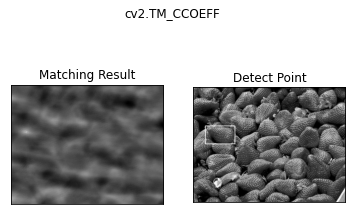

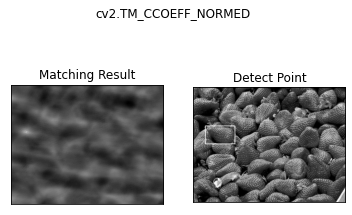

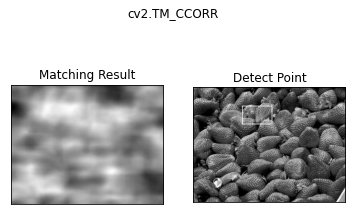

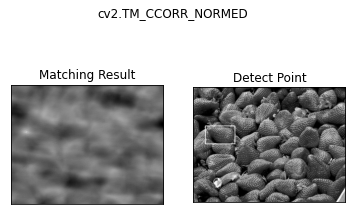

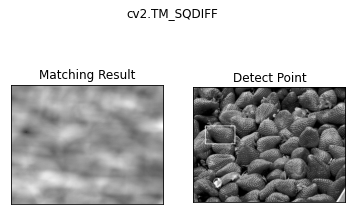

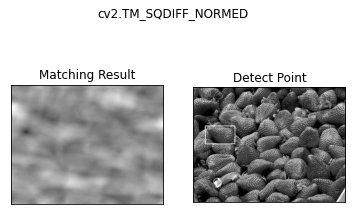

In [10]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

imageFile = "img/st_bg.jpg"
templateFile = "img/st.jpg"

img1 = cv2.imread(imageFile,cv2.IMREAD_GRAYSCALE)
img2 = img1.copy()

temp = cv2.imread(templateFile,cv2.IMREAD_GRAYSCALE)
# 템플릿 이미지의 가로세로 폭을 정의
w,h = temp.shape[::-1]

# for문을 돌리기위해 matchTemplate 함수의 method 인자를 지정
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

# 메소드 배열에 대한 for문
for meth in methods:
    # 이미지가 메소드당 한번씩 출력됨. 현재보고있는 이미지를 끄면 그다음 for문의 메소드 결과값 출력
    img1 = img2.copy()
    # for 문이 돌아갈때마다 다른 method 의 값을 method 함수에 담아줌
    method = eval(meth)

    # 각각의 method 값에 의한 템플릿 매칭 시작
    try:
        res = cv2.matchTemplate(img1,temp,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    except:
        print("error",meth)
        continue

    # TM_SQDIFF 와 TM_SQDIFF_NORMED 는 최소값을 사용함. 그외는 다 최대값
    # top_left의 좌표가 해당 템플릿이 위치한 왼쪽 위의 좌표
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
            top_left = max_loc

    # 템플릿의 오른쪽아래끝 좌표는 top_left 값에서 템플릿이미지의 가로세로		폭을 각좌표에 더해주면됨.
    bottom_right = (top_left[0]+w, top_left[1]+h)
    # 찾은 템플릿이미지에 흰색 사각형을 쳐줌
    cv2.rectangle(img1, top_left, bottom_right, 255, 2)

    # matplotlib 를 이용한 비교 gui 작성
    plt.subplot(121)
    plt.imshow(res,cmap='gray')
    plt.title('Matching Result')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(122)
    plt.imshow(img1,cmap='gray')
    plt.title('Detect Point')
    plt.xticks([])
    plt.yticks([])
    plt.suptitle(meth)

    plt.show()


템플릿 매칭을 활용한 인쇄체 숫자 인식  
  
인식(Recognition)이란?  
여러 개의 클래스 중에서 가장 유사한 클래스를 선택  
  

In [11]:
import sys
import numpy as np
import cv2


def load_digits():
    img_digits = []

    for i in range(10):
        filename = 'img/digits/digit{}.bmp'.format(i)
        img_digits.append(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))

        if img_digits[i] is None:
            return None

    return img_digits


def find_digit(img, img_digits):
    max_idx = -1
    max_ccoeff = -1

    # 최대 NCC 찾기
    for i in range(10):
        img = cv2.resize(img, (100, 150))
        res = cv2.matchTemplate(img, img_digits[i], cv2.TM_CCOEFF_NORMED)

        if res[0, 0] > max_ccoeff:
            max_idx = i
            max_ccoeff = res[0, 0]

    return max_idx


def main():
    # 입력 영상 불러오기
    src = cv2.imread('img/digits_print.bmp')

    if src is None:
        print('Image load failed!')
        return

    # 100x150 숫자 영상 불러오기
    img_digits = load_digits()  # list of ndarray

    if img_digits is None:
        print('Digit image load failed!')
        return

    # 입력 영상 이진화 & 레이블링
    src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _, src_bin = cv2.threshold(src_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    cnt, _, stats, _ = cv2.connectedComponentsWithStats(src_bin)

    # 숫자 인식 결과 영상 생성
    dst = src.copy()
    for i in range(1, cnt):
        (x, y, w, h, s) = stats[i]

        if s < 1000:
            continue

        # 가장 유사한 숫자 이미지를 선택
        digit = find_digit(src_gray[y:y+h, x:x+w], img_digits)
        cv2.rectangle(dst, (x, y, w, h), (0, 255, 255))
        cv2.putText(dst, str(digit), (x, y - 4), cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('dst', dst)
    cv2.waitKey()
    cv2.destroyAllWindows()


main()


4. 캐스케이드 분류기: 얼굴 검출  
  
유사 하르 특징(Haar-like features)  
• 사각형 형태의 필터 집합을 사용  
• 흰색 사각형 영역 픽셀 값의 합에서 검정색 사각형 영역 픽셀 값을 뺀 결과 값을 추출  
  
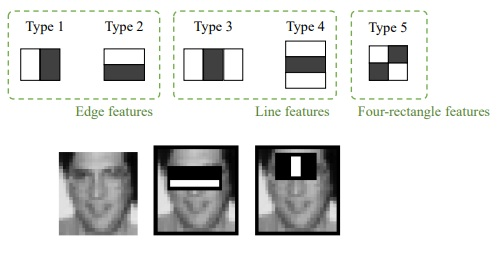  
  
• 24x24 부분 영상에서 얼굴 판별에 유용한 유사 하르 특징을 선별  
  
캐스케이드 분류기(Cascade classifier)  
• 일반적인 영상에는 얼굴이 한 두개 있을 뿐, 나머지 영역은 대부분 non-face 영역  
• Non-face 영역을 빠르게 skip하도록 다단계 검사 수행 영상  
  
cv2.CascadeClassifier 객체 생성 및 학습 데이터 불러오기  
cv2.CascadeClassifier() -> <CascadeClassifier object>  
cv2.CascadeClassifier(filename) -> <CascadeClassifier object>  
  
cv2.CascadeClassifier.load(filename) => retval  
  
filename:XML 파일 이름  
retval:성공하면 True, 실패하면 False  
  
미리 학습된 XML 파일 다운로드  
• https://github.com/opencv/opencv/tree/master/data/haarcascades  
  
<XML 파일 이름>  
정면 얼굴 검출  
haarcascade_frontalface_default.xml  
haarcascade_frontalface_alt.xml  
haarcascade_frontalface_alt2.xml  
haarcascade_frontalface_alt_tree.xml  
  
측면 얼굴 검출  
haarcascade_profileface.xml  
    
웃음 검출  
haarcascade_smile.xml  
    
눈 검출  
haarcascade_eye.xml  
haarcascade_eye_tree_eyeglasses.xml  
haarcascade_lefteye_2splits.xml  
haarcascade_righteye_2splits.xml  
    
고양이 얼굴 검출  
haarcascade_frontalcatface.xml  
haarcascade_frontalcatface_extended.xml  
    
사람의 전신 검출  
haarcascade_fullbody.xml  
    
사람의 상반신 검출  
haarcascade_upperbody.xml  
    
사람의 하반신 검출  
haarcascade_lowerbody.xml  
    
러시아 자동차 번호판 검출  
haarcascade_russian_plate_number.xml  
haarcascade_licence_plate_rus_16stages.xml  
  
<CascadeClassifier 멀티스케일 객체 검출 함수>  
cv2.CascadeClassifier.detectMultiScale(image, scaleFactor=None,
minNeighbors=None, flags=None, minSize=None, maxSize=None) -> result  
  
image: 입력 영상 (cv2.CV_8U)  
scaleFactor: 영상 축소 비율. 기본값은 1.1  
minNeighbors: 얼마나 많은 이웃 사각형이 검출되어야 최종 검출 영역으로 
설정할지를 지정. 기본값은 3.  
flags: (현재) 사용되지 않음  
minSize: 최소 객체 크기. (w, h) 튜플.  
maxSize: 최대 객체 크기. (w, h) 튜플.  
result: 검출된 객체의 사각형 정보(x, y, w, h)를 담은 numpy.ndarray.
shape=(N, 4). dtype=numpy.int32.  

In [12]:
import sys
import numpy as np
import cv2


src = cv2.imread('img/lenna.bmp')

if src is None:
    print('Image load failed!')
    sys.exit()

classifier = cv2.CascadeClassifier('haar/haarcascade_frontalface_alt2.xml')

if classifier.empty():
    print('XML load failed!')
    sys.exit()

faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y, w, h), (255, 0, 255), 2)

cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()


In [1]:
import sys
import numpy as np
import cv2


src = cv2.imread('img/lenna.bmp')

if src is None:
    print('Image load failed!')
    sys.exit()

face_classifier = cv2.CascadeClassifier('haar/haarcascade_frontalface_alt2.xml')
eye_classifier = cv2.CascadeClassifier('haar/haarcascade_eye.xml')

if face_classifier.empty() or eye_classifier.empty():
    print('XML load failed!')
    sys.exit()

faces = face_classifier.detectMultiScale(src)

for (x1, y1, w1, h1) in faces:
    cv2.rectangle(src, (x1, y1), (x1 + w1, y1 + h1), (255, 0, 255), 2)

    faceROI = src[y1:y1 + h1 // 2, x1:x1 + w1]
    eyes = eye_classifier.detectMultiScale(faceROI)

    for (x2, y2, w2, h2) in eyes:
        center = (x2 + w2 // 2, y2 + h2 // 2)
        cv2.circle(faceROI, center, w2 // 2, (255, 0, 0), 2, cv2.LINE_AA)

cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()


In [17]:
import sys
import numpy as np
import cv2


src = cv2.imread('img/car.jpg')

if src is None:
    print('Image load failed!')
    sys.exit()

classifier = cv2.CascadeClassifier('haar/haarcascade_russian_plate_number.xml')

if classifier.empty():
    print('XML load failed!')
    sys.exit()

faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y, w, h), (255, 0, 255), 2)

cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()

In [16]:
import sys
import numpy as np
import cv2


src = cv2.imread('img/street.jpg')

if src is None:
    print('Image load failed!')
    sys.exit()

classifier = cv2.CascadeClassifier('haar/haarcascade_fullbody.xml')

if classifier.empty():
    print('XML load failed!')
    sys.exit()

faces = classifier.detectMultiScale(src)

for (x, y, w, h) in faces:
    cv2.rectangle(src, (x, y, w, h), (255, 0, 255), 2)

cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()

5. HOG 보행자 검출  
  
HOG(Histogram of Oriented Gradients)란?  
• 영상의 지역적 그래디언트 방향 정보를 특징 벡터로 사용  
• 2005년 CVPR 학회에서 보행자 검출 방법으로 소개되어 널리 사용되기 시작함  
• 이후 다양한 객체 인식에서 활용됨  
  
<HOG 알고리즘>  
입력 영상에서 부분 영상 추출 => 크기 정규화(64*128) => 그래디언트 계산 => 8x8 크기의 셀(cell) 분할 => 각 셀마다 방향과 크기 성분을 이용하여 방향 히스토그램 계산  
  
[블록 히스토그램 구하기]  
• 8x8 셀 4개를 하나의 블록을 지정  
→ 즉, 블록 하나의 크기는16x16  
→ 8픽셀 단위로 이동: stride = 8  
→ 각 블록의 히스토그램 빈(bin) 개수는 4x9=36개  
[특징 벡터의 차원]  
하나의 부분 영상 패치에서의 특징 벡터 크기  
→ 7 x 15 x 36 = 3780  
  
HOG 기술자 객체 생성 및 보행자 검출을 위해 학습된 분류기 계수 불러오기  
cv2.HOGDescriptor() -> <CascadeClassifier object>  
cv2.HOGDescriptor_getDefaultPeopleDetector() -> retval  
retval: 미리 훈련된 특징 벡터. numpy.ndarray. shape=(3781, 1). dtype=numpy.float32.  
  
SVM 분류기 계수 등록하기  
cv2.HOGDescriptor.setSVMDetector(svmdetector) -> None  
svmdetector: 선형 SVM 분류기를 위한 계수  
    
HOG 멀티스케일 객체 검출 함수  
cv2.HOGDescriptor.detectMultiScale(img, hitThreshold=None, winStride=None, padding=None, scale=None, finalThreshold=None, 
useMeanshiftGrouping=None) -> foundLocations, foundWeights  
    
img: 입력 영상. cv2.CV_8UC1 또는 cv2.CV_8UC3.  
hitThreshold: 특징 벡터와 SVM 분류 평면까지의 거리에 대한 임계값  
winStride: 셀 윈도우 이동 크기. (0, 0) 지정 시 셀 크기와 같게 설정  
padding: 패딩 크기  
scale: 검색 윈도우 크기 확대 비율. 기본값은 1.05  
finalThreshold: 검출 결정을 위한 임계값  
useMeanshiftGrouping: 겹쳐진 검색 윈도우를 합치는 방법 지정 플래그  
foundLocations: (출력) 검출된 사각형 영역 정보  
foundWeights: (출력) 검출된 사각형 영역에 대한 신뢰도  

In [18]:
import sys
import random
import numpy as np
import cv2

src = cv2.imread('img/street.jpg')

# 보행자 검출을 위한 HOG 기술자 설정
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# 이미지에서 보행자 검출
detected, _ = hog.detectMultiScale(src)

# 검출 결과 화면 표시
for (x, y, w, h) in detected:
    c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    cv2.rectangle(src, (x, y, w, h), c, 3)

cv2.imshow('src', src)
cv2.waitKey()
cv2.destroyAllWindows()


In [19]:
import sys
import random
import numpy as np
import cv2


# 동영상 불러오기
cap = cv2.VideoCapture('img/vtest.avi')

if not cap.isOpened():
    print('Video open failed!')
    sys.exit()

# 보행자 검출을 위한 HOG 기술자 설정
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

while True:
    ret, frame = cap.read()

    if not ret:
        break

    # 매 프레임마다 보행자 검출
    detected, _ = hog.detectMultiScale(frame)

    # 검출 결과 화면 표시
    for (x, y, w, h) in detected:
        c = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        cv2.rectangle(frame, (x, y, w, h), c, 3)

    cv2.imshow('frame', frame)
    if cv2.waitKey(10) == 27:
        break

cv2.destroyAllWindows()


과제: 사진 앱(머리에 왕관, 눈에 안경 등...)  

In [ ]:
import cv2
import numpy as np

cap = cv2.VideoCapture(0)#카메라 오픈
crown_img = cv2.imread('img/crown.png')
crown_img_gray = cv2.cvtColor(crown_img, cv2.COLOR_BGR2GRAY)

mask = np.where(crown_img_gray!=0,255, 0 ).astype('uint8')#배경이 검정, 왕관이 흰색
mask_inv = cv2.bitwise_not(mask)

cr_h, cr_w, _ = crown_img.shape

if not cap.isOpened():# cap.isOpen():카메라 정상오픈이면 True, 아니면 False
    print('카메라 오픈 안됨')
    sys.exit(0)
    
cap.set(3, 600) 
cap.set(4, 400)

classifier = cv2.CascadeClassifier('haar/haarcascade_frontalface_alt2.xml')

if classifier.empty():
    print('XML load failed!')
    sys.exit()

while True:
    ret, frame = cap.read() 
    if ret: #정상 읽기일 때만
        faces = classifier.detectMultiScale(frame)
        
    for (x, y, w, h) in faces:
        #cv2.rectangle(frame, (x, y, w, h), (0, 0, 255), 2)
        cx = x+w//2-cr_w//2
        cy = y-15-cr_h
        cr_roi = frame[cy:cy+cr_h, cx:cx+cr_w]
        roi = cv2.bitwise_and(cr_roi, cr_roi,mask_inv)
        crown = cv2.bitwise_and(crown_img, crown_img,mask)
        res = cv2.add(crown, roi)
        frame[cy:cy+cr_h, cx:cx+cr_w] = res
        
    cv2.imshow('img', frame) #영상을 윈도우에 출력    
    k = cv2.waitKey(100)
    if k==27: #입력한 키가 esc이면
        break
cap.release()
cv2.destroyAllWindows()